
# Notebook Description

- The original challenge used 10 folds
- This workbook generates files for the 10 folds that can be used in both:
    - GRT123
    - MONAI Detection


<mark>The SUMMIT protocol determines nodules >4mm so we need to make this consistent with LUNA. This notebook additionally excludes nodules &lt;4mm</mark>

From previous experiments it has been determined that MONAI detection should only be trained using positive samples whereas GRT123 performs better when a combination of positive and negative samples are used in training.

<mark>NOTE: The folds are zero-indexed</mark>

### GRT123

Training regime will be 10 training runs, each one exclude one fold and validate on the held out fold

Folder structure:
- root/metadata/luna/10folds/fold1/training_annotations.csv       ... fold1-fold9 combined
- root/metadata/luna/10folds/fold1/training_scans.csv             ... fold1-fold9 combined
- root/metadata/luna/10folds/fold1/validation_annotations.csv     ... fold0
- root/metadata/luna/10folds/fold1/validation_scans.csv           ... fold0
- ...
- root/metadata/luna/10folds/fold1/training_annotations.csv       ... fold0-fold8 combined
- root/metadata/luna/10folds/fold1/training_scans.csv             ... fold0-fold8 combined
- root/metadata/luna/10folds/fold1/validation_annotations.csv     ... fold9
- root/metadata/luna/10folds/fold1/validation_scans.csv           ... fold9
    
    
<mark>NOTE: Although the GRT123 model uses translated locations for nodules generated through the preprocessing stage, the metadata holds real-world co-ordinates so can be generated from the annotations file. Unless there is a change in the preprocessing step the _label files in the cache directory will hold the correct details of the nodules so will not need to be re-generated</mark>

### MONAI DETECTION

MONAI detection uses a single json file with the training and validation blocks as keys. The original datasplits generated from the paper exclude scans without nodules in both training and validation phase so this should not be used!

It is possible to locate each dataset in 
to a single folder:

Folder structure:
- root/models/detection/datasplits/10folds/datset_fold0.json
    - training: fold1-fold9 (postive samples only)
    - validation: fold0 (all samples)\
- ...
- ...
- root/models/detection/datasplits/10folds/datset_fold9.json
    - training: fold0-fold8 (postive samples only)
    - validation: fold9 (all samples)\

# Code

In [2]:
# libraries
import pandas as pd
from pathlib import Path

currentworkspace = Path.cwd().parent

/Users/john/Projects/SOTAEvaluationNoduleDetection


subset0    89
subset1    89
subset2    89
subset3    89
subset4    89
subset5    89
subset6    89
subset7    89
subset8    88
subset9    88
Name: subset, dtype: int64

Excluded 49 nodules less than 4mm in diameter


Text(0.5, 1.0, 'Histogram of Nodules >= 4mm Diameter')

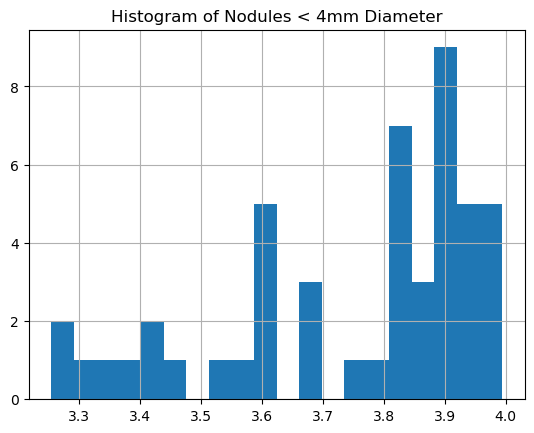

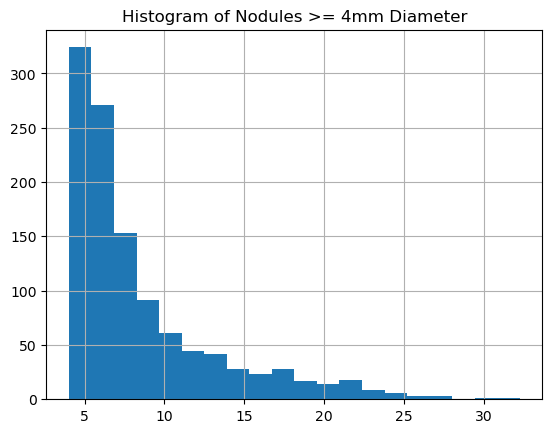

In [16]:
import matplotlib.pyplot as plt
# get the luna folds
luna_subsets = (
    pd.read_csv(f'{currentworkspace}/data/luna/metadata/luna_subsets.csv', header=None)
    .rename(columns={0: 'subset', 1: 'scan_id'})
)

display(luna_subsets.subset.value_counts())

# get the luna annotations
luna_annotations = (
    pd.read_csv(f'{currentworkspace}/data/luna/metadata/annotations.csv')
    .rename(columns={'seriesuid': 'scan_id'})
)


# exclude all nodules less than 4mm
nodule_count_before_exclusions = luna_annotations.shape[0]
excluded_nodules = luna_annotations[luna_annotations.diameter_mm < 4]
luna_annotations = luna_annotations[luna_annotations.diameter_mm >= 4]
nodule_count_after_exclusions = luna_annotations.shape[0]

print(f'Excluded {nodule_count_before_exclusions - nodule_count_after_exclusions} nodules less than 4mm in diameter')


excluded_nodules.hist('diameter_mm', bins=20)
plt.title('Histogram of Nodules < 4mm Diameter')

luna_annotations.hist('diameter_mm', bins=20)
plt.title('Histogram of Nodules >= 4mm Diameter')


## GRT123 Processing

In [17]:
for subset in luna_subsets.subset.unique():

    ouput_path = Path(f'{currentworkspace}/metadata/luna/10folds/{subset}')
    ouput_path.mkdir(parents=True, exist_ok=True)

    print(ouput_path)

    validation_scan_ids = luna_subsets[luna_subsets.subset == subset].scan_id.values
    validation_annotations = luna_annotations[luna_annotations.scan_id.isin(validation_scan_ids)]

    pd.DataFrame(validation_scan_ids, columns=['scan_id']).to_csv(ouput_path / 'validation_scans.csv', index=False)
    validation_annotations.to_csv(ouput_path / 'validation_annotations.csv', index=False)

    training_scan_ids = luna_subsets[luna_subsets.subset != subset].scan_id.values
    training_annotations = luna_annotations[luna_annotations.scan_id.isin(training_scan_ids)]

    pd.DataFrame(training_scan_ids, columns=['scan_id']).to_csv(ouput_path / 'training_scans.csv', index=False)
    training_annotations.to_csv(ouput_path / 'training_annotations.csv', index=False)

    print(f"{subset} subset: {len(training_scan_ids)} training scans, {len(validation_scan_ids)} validation scans")
    print(f"{subset} subset: {len(training_annotations)} training annotations, {len(validation_annotations)} validation annotations")


/Users/john/Projects/SOTAEvaluationNoduleDetection/metadata/luna/10folds/subset0
subset0 subset: 799 training scans, 89 validation scans
subset0 subset: 1029 training annotations, 108 validation annotations
/Users/john/Projects/SOTAEvaluationNoduleDetection/metadata/luna/10folds/subset1
subset1 subset: 799 training scans, 89 validation scans
subset1 subset: 1017 training annotations, 120 validation annotations
/Users/john/Projects/SOTAEvaluationNoduleDetection/metadata/luna/10folds/subset2
subset2 subset: 799 training scans, 89 validation scans
subset2 subset: 1012 training annotations, 125 validation annotations
/Users/john/Projects/SOTAEvaluationNoduleDetection/metadata/luna/10folds/subset3
subset3 subset: 799 training scans, 89 validation scans
subset3 subset: 1026 training annotations, 111 validation annotations
/Users/john/Projects/SOTAEvaluationNoduleDetection/metadata/luna/10folds/subset4
subset4 subset: 799 training scans, 89 validation scans
subset4 subset: 1012 training annot

## MONAI Detection Processing

In [20]:
import json

def create_dataset_json(validation_scan_ids, validation_annotations, training_scan_ids, training_annotations):
    
    dataset_json = {
        'training' : [],
        'validation' : [],
        'test' : []
    }
    number_scans_without_annotations = 0
    number_scans_with_annotations = 0

    # only include scans with annotations
    for scan_id in training_scan_ids:
        annotations = training_annotations[training_annotations.scan_id == scan_id]
        if len(annotations) > 0:
            annotation_dict = {'box' : [], 'image' : '', 'label' : []}
            annotation_dict['image'] = f"{scan_id}/{scan_id}.nii.gz"

            for idx, annotation in annotations.iterrows():
                annotation_dict['box'].append(
                    [
                        annotation['coordX'],
                        annotation['coordY'], 
                        annotation['coordZ'], 
                        annotation['diameter_mm'], 
                        annotation['diameter_mm'], 
                        annotation['diameter_mm']
                    ])
                annotation_dict['label'].append(0)

            dataset_json['training'].append(annotation_dict)
            number_scans_with_annotations += 1
        else:
            number_scans_without_annotations += 1

    # include all validation scans
    for scan_id in validation_scan_ids:
        annotations = validation_annotations[validation_annotations.scan_id == scan_id]
        annotation_dict = {'box' : [], 'image' : '', 'label' : []}
        annotation_dict['image'] = f"{scan_id}/{scan_id}.nii.gz"
        for idx, annotation in annotations.iterrows():
            annotation_dict['box'].append(
                [
                    annotation['coordX'],
                    annotation['coordY'], 
                    annotation['coordZ'], 
                    annotation['diameter_mm'], 
                    annotation['diameter_mm'], 
                    annotation['diameter_mm']
                ])
            annotation_dict['label'].append(0)

        dataset_json['validation'].append(annotation_dict)

    return dataset_json, number_scans_with_annotations, number_scans_without_annotations

output_path = Path(f'{currentworkspace}/models/detection/datasplits/luna/10folds')

for subset in luna_subsets.subset.unique():

    validation_scan_ids = luna_subsets[luna_subsets.subset == subset].scan_id.values
    validation_annotations = luna_annotations[luna_annotations.scan_id.isin(validation_scan_ids)]

    training_scan_ids = luna_subsets[luna_subsets.subset != subset].scan_id.values
    training_annotations = luna_annotations[luna_annotations.scan_id.isin(training_scan_ids)]

    dataset_json, number_scans_with_annotations, number_scans_without_annotations = create_dataset_json(validation_scan_ids, 
                                                                                                        validation_annotations,
                                                                                                        training_scan_ids,
                                                                                                        training_annotations)
    
    print(f"{subset} subset: {number_scans_with_annotations} training scans with annotations, {number_scans_without_annotations} without annotations")
    print(f"dataset_json check: {len(dataset_json['training'])} training scans, {len(dataset_json['validation'])} validation scans")
    print(f"{subset} subset: {len(validation_scan_ids)} validation scans with annotations")

    with open(output_path / f'dataset_{subset}.json', 'w') as f:
        json.dump(dataset_json, f, indent=4)

subset0 subset: 522 training scans with annotations, 277 without annotations
dataset_json check: 522 training scans, 89 validation scans
subset0 subset: 89 validation scans with annotations
subset1 subset: 530 training scans with annotations, 269 without annotations
dataset_json check: 530 training scans, 89 validation scans
subset1 subset: 89 validation scans with annotations
subset2 subset: 532 training scans with annotations, 267 without annotations
dataset_json check: 532 training scans, 89 validation scans
subset2 subset: 89 validation scans with annotations
subset3 subset: 523 training scans with annotations, 276 without annotations
dataset_json check: 523 training scans, 89 validation scans
subset3 subset: 89 validation scans with annotations
subset4 subset: 526 training scans with annotations, 273 without annotations
dataset_json check: 526 training scans, 89 validation scans
subset4 subset: 89 validation scans with annotations
subset5 subset: 534 training scans with annotation